In [2]:
from pathlib import Path

import pandas as pd
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

In [3]:
import bioemu

In [4]:
from bioemu import observables_ddr as observables

/scratch/users/ddrichma/micromamba/envs/mamba250530-bioemu-ft/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [5]:
observables.compute_h_for_grb2_sh3

<function bioemu.observables_ddr.compute_h_for_grb2_sh3(pos: torch.Tensor, node_orientations: torch.Tensor, ref_path: str) -> torch.Tensor>

In [6]:
def read_dir(output_dir):
    samples_files = sorted(list(output_dir.glob("batch_*.npz")))
    data = [np.load(f) for f in samples_files]
    sequences = [d["sequence"].item() for d in data]
    if len(set(sequences)) != 1:
        raise ValueError(f"Expected all sequences to be {sequences[0]}, but got {set(sequences)}")
    positions = torch.tensor(np.concatenate([d["pos"] for d in data]))
    node_orientations = torch.tensor(
        np.concatenate([d["node_orientations"] for d in data])
    )

    return sequences[0], positions, node_orientations

# Quick check of wild type protein

In [7]:
_, wt_pos, wt_orientations = read_dir(Path('../../bioemu-testing/protein_results/grb2-sh3/test0/wt/'))

In [8]:
h = observables.compute_h_for_grb2_sh3(wt_pos, wt_orientations, "structures/2vwf_trimmed_SH3.pdb")

tensor([[-0.9968,  1.1132,  0.4256],
        [-0.4432,  0.8414,  0.4743],
        [ 0.2263,  0.3035,  0.1534],
        [ 0.5562,  0.4611,  0.0487],
        [ 0.4019,  0.9670,  0.1382],
        [ 0.0669,  1.7132, -1.0830],
        [-0.3250,  1.3568, -0.8720],
        [-0.0293,  1.3910, -0.6372],
        [ 0.3041,  1.8315, -0.2155],
        [ 0.3412,  1.4259, -0.0756],
        [-0.2934,  1.2129, -0.3032],
        [-0.8611,  1.2795, -0.3447],
        [-0.8300,  1.2817,  0.0315]]) tensor([[-0.9978,  1.0783,  0.4998],
        [-0.4135,  0.8576,  0.4682],
        [ 0.2824,  0.3048,  0.2305],
        [ 0.5921,  0.4418,  0.0479],
        [ 0.3954,  0.9737,  0.1358],
        [ 0.0818,  1.7404, -1.0438],
        [-0.3077,  1.3683, -0.9147],
        [-0.0718,  1.3894, -0.6184],
        [ 0.2900,  1.7750, -0.1980],
        [ 0.2855,  1.3707, -0.1119],
        [-0.3576,  1.2204, -0.3421],
        [-0.8679,  1.3664, -0.3901],
        [-0.7932,  1.2919, -0.0227]])


(array([ 60.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 940.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.90000004,
        1.        ]),
 <BarContainer object of 10 artists>)

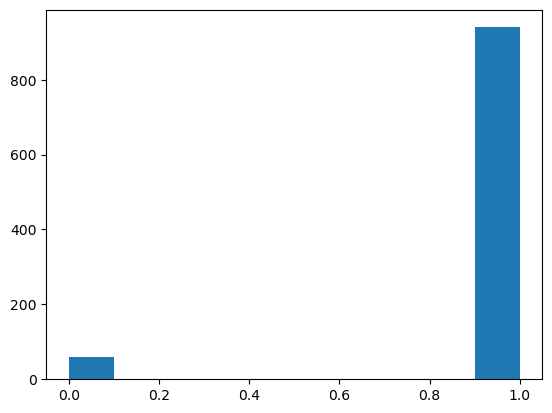

In [9]:
plt.hist(h[:, 0])

# Plot non-ft BioEmu results for many mutants

In [10]:
records = []
for mutation_dir in Path('../../bioemu-testing/protein_results/grb2-sh3/test0/').glob('*'):
    mutation_name = mutation_dir.name
    print(mutation_name)
    _, pos, orientations = read_dir(mutation_dir)
    h = observables.compute_h_for_grb2_sh3(pos, orientations, "structures/2vwf_trimmed_SH3.pdb")

    # rough proxy for dg_binding
    h_folded, h_bindable = h[:, 0], h[:, 1]
    dg_folding = -np.log((h_folded == 1).sum() / (h_folded == 0).sum()).item()
    dg_binding = -np.log((h_bindable == 1).sum() / (h_bindable == 0).sum()).item()

    # bootstrapping for error estimates
    bootstrap_dg_f = [-np.log((np.random.choice(h_folded, len(h_folded)) == 1).sum() / (np.random.choice(h_folded, len(h_folded)) == 0).sum()) for _ in range(1000)]
    bootstrap_dg_b = [-np.log((np.random.choice(h_bindable, len(h_bindable)) == 1).sum() / (np.random.choice(h_bindable, len(h_bindable)) == 0).sum()) for _ in range(1000)]

    dg_folding_err, dg_binding_err = np.std(bootstrap_dg_f), np.std(bootstrap_dg_b)
    
    records.append((mutation_name, dg_folding, dg_binding, dg_folding_err, dg_binding_err))

F19I
tensor([[-1.0306,  1.1105,  0.4595],
        [-0.4530,  0.8342,  0.4461],
        [ 0.2850,  0.2773,  0.2155],
        [ 0.6068,  0.4592,  0.0079],
        [ 0.4274,  1.0128,  0.1387],
        [ 0.0497,  1.7558, -1.0836],
        [-0.2873,  1.3282, -0.8677],
        [-0.0242,  1.3391, -0.6196],
        [ 0.2990,  1.7847, -0.1882],
        [ 0.2994,  1.3697, -0.1072],
        [-0.3684,  1.2293, -0.2902],
        [-0.8646,  1.3584, -0.3739],
        [-0.8216,  1.3196,  0.0032]]) tensor([[-0.9978,  1.0783,  0.4998],
        [-0.4135,  0.8576,  0.4682],
        [ 0.2824,  0.3048,  0.2305],
        [ 0.5921,  0.4418,  0.0479],
        [ 0.3954,  0.9737,  0.1358],
        [ 0.0818,  1.7404, -1.0438],
        [-0.3077,  1.3683, -0.9147],
        [-0.0718,  1.3894, -0.6184],
        [ 0.2900,  1.7750, -0.1980],
        [ 0.2855,  1.3707, -0.1119],
        [-0.3576,  1.2204, -0.3421],
        [-0.8679,  1.3664, -0.3901],
        [-0.7932,  1.2919, -0.0227]])
F19L


/tmp/ipykernel_201159/629406563.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dg_folding = -np.log((h_folded == 1).sum() / (h_folded == 0).sum()).item()
/tmp/ipykernel_201159/629406563.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dg_binding = -np.log((h_bindable == 1).sum() / (h_bindable == 0).sum()).item()


tensor([[-1.0308,  1.1041,  0.4754],
        [-0.4607,  0.8287,  0.4522],
        [ 0.2794,  0.2739,  0.2095],
        [ 0.6009,  0.4646,  0.0101],
        [ 0.4307,  1.0162,  0.1420],
        [ 0.0568,  1.7529, -1.0845],
        [-0.2849,  1.3280, -0.8750],
        [-0.0264,  1.3419, -0.6255],
        [ 0.2922,  1.7878, -0.1880],
        [ 0.3018,  1.3716, -0.1114],
        [-0.3652,  1.2318, -0.2944],
        [-0.8601,  1.3542, -0.3734],
        [-0.8161,  1.3231,  0.0035]]) tensor([[-0.9978,  1.0783,  0.4998],
        [-0.4135,  0.8576,  0.4682],
        [ 0.2824,  0.3048,  0.2305],
        [ 0.5921,  0.4418,  0.0479],
        [ 0.3954,  0.9737,  0.1358],
        [ 0.0818,  1.7404, -1.0438],
        [-0.3077,  1.3683, -0.9147],
        [-0.0718,  1.3894, -0.6184],
        [ 0.2900,  1.7750, -0.1980],
        [ 0.2855,  1.3707, -0.1119],
        [-0.3576,  1.2204, -0.3421],
        [-0.8679,  1.3664, -0.3901],
        [-0.7932,  1.2919, -0.0227]])
L6I
tensor([[-1.0305,  1.0974,  0.45

In [11]:
h[:,0]

tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

<Axes: ylabel='Count'>

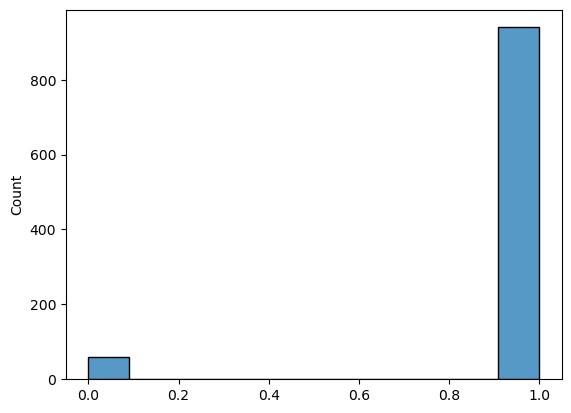

In [12]:
sns.histplot(h[:,0])

In [13]:
records

[('F19I',
  -2.4288370609283447,
  -2.05051851272583,
  np.float64(0.1051632392390338),
  np.float64(0.09149700200963087)),
 ('F19L',
  -2.277543067932129,
  -1.8746898174285889,
  np.float64(0.09993431505083071),
  np.float64(0.08333929307066695)),
 ('L6I',
  -3.009467363357544,
  -2.5268092155456543,
  np.float64(0.1387560514935668),
  np.float64(0.11062189325356443)),
 ('wt',
  -2.751535415649414,
  -2.26574444770813,
  np.float64(0.1252503980055619),
  np.float64(0.09856002370958472)),
 ('T53G',
  -2.2894558906555176,
  -1.9367984533309937,
  np.float64(0.10253224286994965),
  np.float64(0.08564422762261825)),
 ('H26T',
  -2.4423470497131348,
  -2.1428632736206055,
  np.float64(0.10936889324014054),
  np.float64(0.08972622580083599)),
 ('W36K',
  -1.2598483562469482,
  -0.9643905758857727,
  np.float64(0.06343303431379006),
  np.float64(0.054853713280299116)),
 ('P11L',
  -2.6995484828948975,
  -2.001934051513672,
  np.float64(0.12370835609334137),
  np.float64(0.08701804791921476)

In [14]:
bioemu_non_ft_predictions = pd.DataFrame.from_records(records, columns=['id', 'dg_folding_est', 'dg_binding_est', 'dg_folding_err', 'dg_binding_err'])

# Adjust to ddgs. What we're estimating here is really something like a dg from "bindable" to nonbindable
# which can be viewed as a ddg of binding
#wt_est = bioemu_non_ft_predictions.loc[bioemu_non_ft_predictions['id'] == 'wt', 'dg_binding_est'].item()
#bioemu_non_ft_predictions['ddg_binding_est'] -= wt_est
# for purposes of h* it's easier just to stick with dg

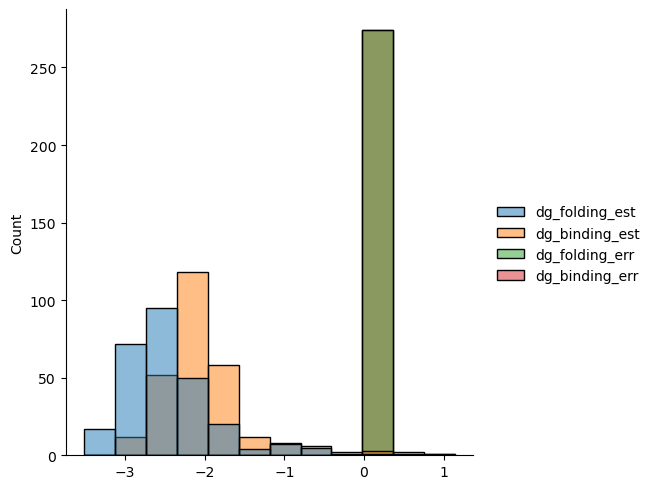

In [15]:
sns.displot(bioemu_non_ft_predictions)

# Compare to ground truth

In [16]:
gt_data = pd.read_csv('reference_h/GRB2_SH3_high_confidence.csv')
gt_data.loc[gt_data.id == '-0-', 'id'] = 'wt' # rename wt row

In [17]:
combined_df = gt_data.merge(bioemu_non_ft_predictions)

In [18]:
combined_df.columns

Index(['Pos_ref', 'id', 'id_ref', 'Pos', 'mut_order', 'f_dg_pred',
       'f_ddg_pred', 'f_ddg_pred_sd', 'b_dg_pred', 'b_ddg_pred',
       'b_ddg_pred_sd', 'f_ddg_pred_conf', 'b_ddg_pred_conf', 'HAmin_ligand',
       'scHAmin_ligand', 'RSASA', 'SS', 'Pos_class', 'protein', 'WT_AA', 'Mut',
       'b_ddg_wposmeanabs', 'b_ddg_wposse', 'allosteric', 'orthosteric',
       'allosteric_mutation', 'seq', 'prob_folded', 'prob_bound',
       'dg_folding_est', 'dg_binding_est', 'dg_folding_err', 'dg_binding_err'],
      dtype='object')

In [19]:
combined_df.loc[combined_df.id=='wt', 'Pos_class'] = 'wt'

Text(0.5, 28.999999999999986, 'Estimated $\\Delta G_{fold}$ from BioEmu')

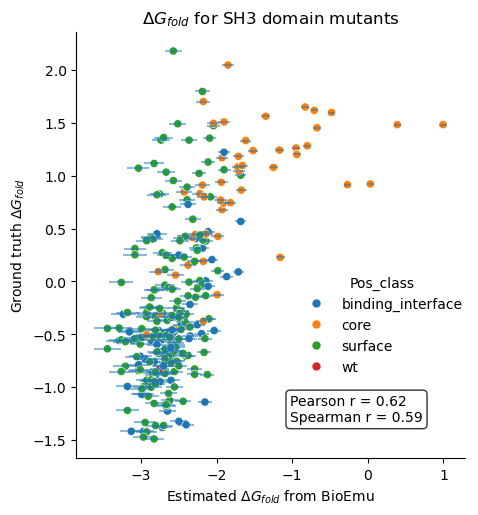

In [20]:
g = sns.relplot(combined_df, y='f_dg_pred', x='dg_folding_est', hue='Pos_class')
sns.move_legend(g, loc='lower right', bbox_to_anchor=(.75, .26))
g.ax.errorbar(combined_df['dg_folding_est'], combined_df['f_dg_pred'], xerr=combined_df['dg_folding_err'], fmt='none', alpha=0.5)
pearson_r = scipy.stats.pearsonr(combined_df['f_dg_pred'], combined_df['dg_folding_est'])[0]
spearman_r = scipy.stats.spearmanr(combined_df['f_dg_pred'], combined_df['dg_folding_est'])[0]
g.ax.text(0.55, 0.15, f'Pearson r = {pearson_r:.2f}\nSpearman r = {spearman_r:.2f}', transform=g.ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title(r'$\Delta G_{fold}$ for SH3 domain mutants')
plt.ylabel(r'Ground truth $\Delta G_{fold}$')
plt.xlabel(r'Estimated $\Delta G_{fold}$ from BioEmu')

In [21]:
for c in set(combined_df['Pos_class']):
    df_subset = combined_df[combined_df['Pos_class'] == c]
    print(c, scipy.stats.spearmanr(df_subset.f_ddg_pred, df_subset.dg_folding_est))

binding_interface SignificanceResult(statistic=np.float64(0.5307723679902361), pvalue=np.float64(2.1641598403444836e-05))
wt SignificanceResult(statistic=nan, pvalue=nan)
surface SignificanceResult(statistic=np.float64(0.3672815913241005), pvalue=np.float64(2.226620644810021e-06))
core SignificanceResult(statistic=np.float64(0.6948733391420449), pvalue=np.float64(2.1632227086809718e-08))


Text(0.5, 9.444444444444438, 'Estimated $\\Delta \\Delta G_{bind}$ from BioEmu')

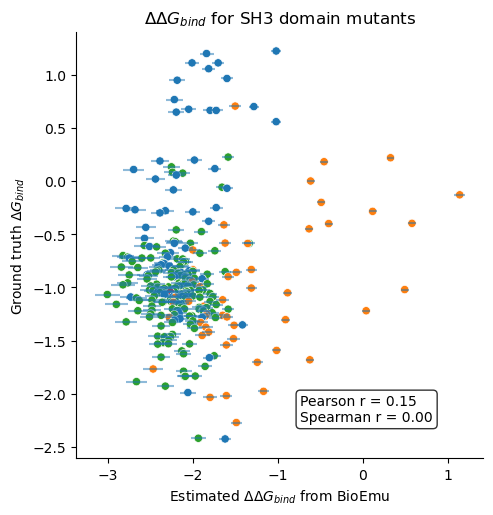

In [22]:

g = sns.relplot(combined_df, y='b_dg_pred', x='dg_binding_est', hue='Pos_class', legend=False)
#sns.move_legend(g, 'upper right', bbox_to_anchor=(.75, .97))
g.ax.errorbar( combined_df['dg_binding_est'], combined_df['b_dg_pred'], xerr=combined_df['dg_binding_err'], fmt='none', alpha=0.5)
pearson_r = scipy.stats.pearsonr(combined_df['b_dg_pred'], combined_df['dg_binding_est'])[0]
spearman_r = scipy.stats.spearmanr(combined_df['b_dg_pred'], combined_df['dg_binding_est'])[0]
g.ax.text(0.55, 0.15, f'Pearson r = {pearson_r:.2f}\nSpearman r = {spearman_r:.2f}', transform=g.ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.title(r'$\Delta \Delta G_{bind}$ for SH3 domain mutants')
plt.ylabel(r'Ground truth $\Delta G_{bind}$')
plt.xlabel(r'Estimated $\Delta \Delta G_{bind}$ from BioEmu')

In [23]:
set(combined_df[combined_df['Pos_class'] == 'binding_interface'].Pos)

{7.0, 9.0, 12.0, 13.0, 16.0, 32.0, 34.0, 35.0, 37.0, 46.0, 48.0, 50.0, 51.0}

Text(0.5, 9.444444444444438, 'Estimated $\\Delta G_{bind}$ from BioEmu')

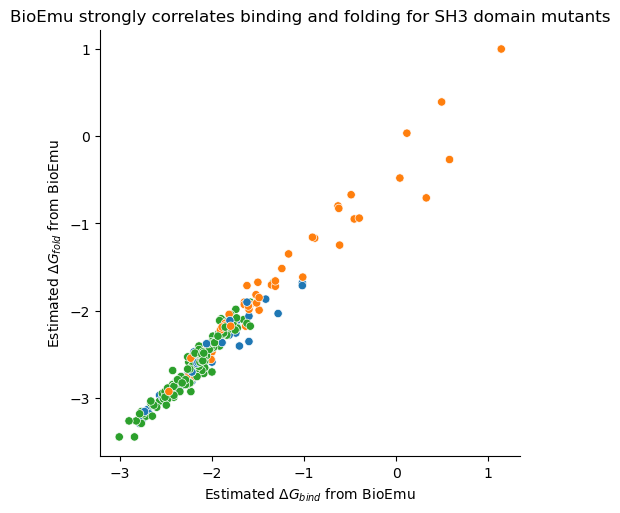

In [31]:

g = sns.relplot(combined_df, y='dg_folding_est', x='dg_binding_est', hue='Pos_class', legend=False)
#sns.move_legend(g, 'upper right', bbox_to_anchor=(.75, .97))
plt.title(r'BioEmu strongly correlates binding and folding for SH3 domain mutants')
plt.ylabel(r'Estimated $\Delta G_{fold}$ from BioEmu')
plt.xlabel(r'Estimated $\Delta G_{bind}$ from BioEmu')

Text(0.5, 9.444444444444438, 'Measured $\\Delta G_{bind}$')

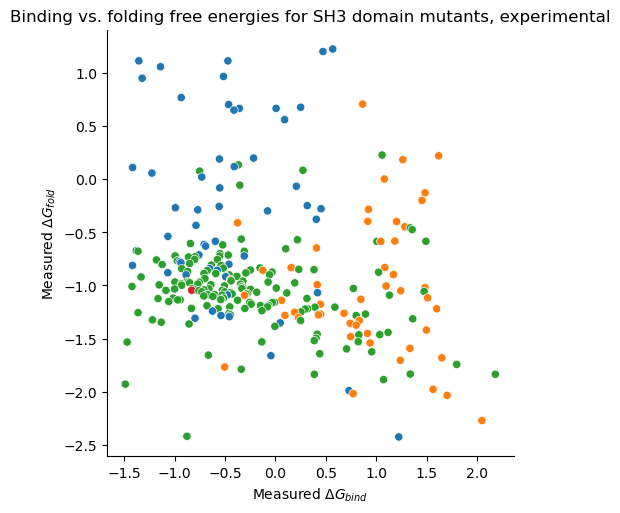

In [25]:

g = sns.relplot(combined_df, y='b_dg_pred', x='f_dg_pred', hue='Pos_class', legend=False)
#sns.move_legend(g, 'upper right', bbox_to_anchor=(.75, .97))
plt.title(r'Binding vs. folding free energies for SH3 domain mutants, experimental')
plt.ylabel(r'Measured $\Delta G_{fold}$')
plt.xlabel(r'Measured $\Delta G_{bind}$')

Text(0.5, 28.999999999999986, 'Estimated $\\Delta G_{bind}$ from BioEmu')

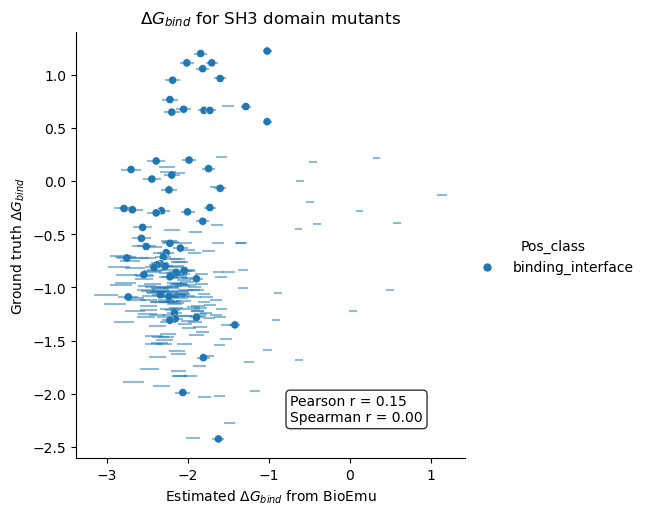

In [26]:

g = sns.relplot(combined_df[combined_df.Pos_class == 'binding_interface'], y='b_dg_pred', x='dg_binding_est', hue='Pos_class')
#sns.move_legend(g, 'upper right')
g.ax.errorbar( combined_df['dg_binding_est'], combined_df['b_dg_pred'], xerr=combined_df['dg_binding_err'], fmt='none', alpha=0.5)
pearson_r = scipy.stats.pearsonr(combined_df['b_dg_pred'], combined_df['dg_binding_est'])[0]
spearman_r = scipy.stats.spearmanr(combined_df['b_dg_pred'], combined_df['dg_binding_est'])[0]
g.ax.text(0.55, 0.15, f'Pearson r = {pearson_r:.2f}\nSpearman r = {spearman_r:.2f}', transform=g.ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.title(r'$\Delta G_{bind}$ for SH3 domain mutants')
plt.ylabel(r'Ground truth $\Delta G_{bind}$')
plt.xlabel(r'Estimated $\Delta G_{bind}$ from BioEmu')

In [27]:
scipy.stats.spearmanr(combined_df.b_ddg_pred, combined_df.dg_binding_est)

SignificanceResult(statistic=np.float64(0.0035581588993540652), pvalue=np.float64(0.9540282199493275))

In [28]:
for c in set(combined_df['Pos_class']):
    df_subset = combined_df[combined_df['Pos_class'] == c]
    print(c, scipy.stats.spearmanr(df_subset.b_ddg_pred, df_subset.dg_binding_est))

binding_interface SignificanceResult(statistic=np.float64(0.26126141968120925), pvalue=np.float64(0.0496435960131398))
wt SignificanceResult(statistic=nan, pvalue=nan)
surface SignificanceResult(statistic=np.float64(-0.05730896371173037), pvalue=np.float64(0.4758907847612509))
core SignificanceResult(statistic=np.float64(0.35951495036404374), pvalue=np.float64(0.010340741220210607))


# test h_star code

In [29]:
observables.h_star_for_grb2_sh3('reference_h/GRB2_SH3_high_confidence.csv')

(0      TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTHM...
 1      TYVQALFDCDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 2      TYVQALFDVDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 3      TYVQALIDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 4      TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNRWKGACHGQTGM...
                              ...                        
 584    TYVQALFCFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 585    TYVQALFDFDPQEDGELGFRRGYFIHVMDNSDPNWWKGACHGQTGM...
 586    TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 587    TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWDGACHGQTGM...
 588    TYVNALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 Name: seq, Length: 589, dtype: object,
 tensor([[0.1976, 0.0045],
         [0.5153, 0.1624],
         [0.5799, 0.1986],
         ...,
         [0.7065, 0.9182],
         [0.2275, 0.9187],
         [0.2778, 0.9362]]))